# Tobacco trial classification
In this notebook we will try to classify 13M~ documents into 10 classes. 

The data is available in two different ways :
    - Textual data 
    - Images of the documents
    

### Necessary import (Make sure you can run this before running the script )

In [11]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing.text import text_to_word_sequence
from keras.utils import to_categorical


#### Opening metadata

In [2]:
meta_data = pd.read_csv("data/Tobacco3482.csv")

# Here I'm extracting the label
labels = np.unique(meta_data["label"])

#### Opening data

In [3]:
x = []
y = []
for l in labels :
    path = 'data/'+l+"/*.txt"
    print("Opening "+ l +" data")
    files=glob.glob(path)   
    for file in files:
        f=open(file, 'r')  
        x.append(f.read())
        y.append(l)
        f.close()
print("Opened "+str(len(x))+" documents, "+str(len(np.unique(y)))+" different classes" )

Opening Advertisement data
Opening Email data
Opening Form data
Opening Letter data
Opening Memo data
Opening News data
Opening Note data
Opening Report data
Opening Resume data
Opening Scientific data
Opened 3482 documents, 10 different classes


# Statistical analysis of the data

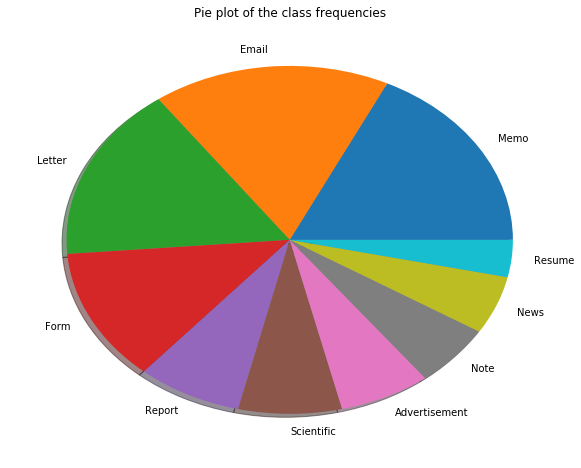

In [4]:
counts =meta_data["label"].value_counts()
plt.figure(1,figsize = (10,8))
plt.title("Pie plot of the class frequencies")
plt.pie(counts,labels = counts.index,shadow = True)
plt.show()

We can see that the classes are not very unbalanced even though 3 classes form half the data but given that they are Letter, Email and Memo, it's a normal behaviour given how the data were acquired

#### Pre-treatment of the data 

In [6]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.6 , random_state = 42)
x_test,x_val,y_test,y_val = train_test_split(x_test,y_test, test_size=0.5 , random_state = 42)

In [7]:
sentences = [text_to_word_sequence(s) for s in x]

vectorizer = CountVectorizer(max_features=1000)
vectorizer.fit(x_train)

x_train_counts = vectorizer.transform(x_train)
x_val_counts = vectorizer.transform(x_val)
x_test_counts = vectorizer.transform(x_test)

x_train_tfidf= TfidfTransformer().fit_transform(x_train_counts)
x_val_tfidf= TfidfTransformer().fit_transform(x_val_counts)
x_test_tfidf= TfidfTransformer().fit_transform(x_test_counts)


In [15]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(x_train_tfidf,y_train)
clf.score(x_val_tfidf,y_val)

0.6555023923444976

# Neural network part

#### Tokenization part

In [8]:
def tokenize(sentences,tokenizer,maxlen=None):
    sequences  = toke.texts_to_sequences(sentences)
    sequences  = np.array(sequences)
    sequences = pad_sequences(sequences,maxlen=maxlen)    
    for i in range(len(sequences)):
        sequences[i] = np.flip(sequences[i],axis=0)
    return sequences 

In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
toke = Tokenizer(5000)
toke.fit_on_texts(sentences)
encoded = tokenize(sentences,toke)
print(encoded.shape)

(3482, 1238)


In [12]:
from sklearn.model_selection import train_test_split
y = to_categorical(y)
x_train,x_test,y_train,y_test = train_test_split(encoded,y,test_size=0.2,random_state = 42)

In [20]:
# Neural Network
from keras.layers import Input, Dense,Activation,Convolution1D,Flatten,MaxPooling1D,Conv1D,LSTM,Dropout, Embedding
from keras.models import Model

def model_creation(sentence_length):
    
    WORD_LENGTH=1
    max_len=sentence_length
    inputs = Input(shape = (max_len,))
    emb = Embedding(5000,300)(inputs)
    x = Dropout(0.5)(emb)
    x = Convolution1D(64,kernel_size=10,activation='relu',padding='causal')(x)
    x = Dropout(0.5)(x)
    x = MaxPooling1D(pool_size=2, strides=None, padding='same')(x)
    x = LSTM(25)(x)
    x = Dropout(0.5)(x)
    output = Dense(10,activation = "softmax")(x)
    
    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [21]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)
callbacks=[checkpointer]

NN = model_creation(len(encoded[0]))
NN.fit(x_train,y_train,epochs=5,validation_split=0.1,batch_size = 32,callbacks=[checkpointer])
NN.load_weights('weights.hdf5')


/home/robin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, kernel_size=10, activation="relu", padding="causal")`
  if sys.path[0] == '':


Train on 2506 samples, validate on 279 samples
Epoch 1/5
2506/2506 [==============================] - 79s 32ms/step - loss: 0.3186 - acc: 0.9000 - val_loss: 0.3159 - val_acc: 0.9000

Epoch 00001: val_loss improved from inf to 0.31586, saving model to weights.hdf5
Epoch 2/5
2506/2506 [==============================] - 76s 30ms/step - loss: 0.3153 - acc: 0.9000 - val_loss: 0.3125 - val_acc: 0.9000

Epoch 00002: val_loss improved from 0.31586 to 0.31252, saving model to weights.hdf5
Epoch 3/5
2506/2506 [==============================] - 78s 31ms/step - loss: 0.3142 - acc: 0.9000 - val_loss: 0.3118 - val_acc: 0.9000

Epoch 00003: val_loss improved from 0.31252 to 0.31184, saving model to weights.hdf5
Epoch 4/5
2506/2506 [==============================] - 79s 31ms/step - loss: 0.3139 - acc: 0.9000 - val_loss: 0.3122 - val_acc: 0.9000

Epoch 00004: val_loss did not improve from 0.31184
Epoch 5/5
2506/2506 [==============================] - 82s 33ms/step - loss: 0.3143 - acc: 0.9000 - val_los

In [22]:
NN.evaluate(x_test,y_test)

697/697 [==============================] - 6s 8ms/step


[0.31011200216271445, 0.8999999761581421]

#### Word2Vec part

In [23]:
def load_google_word2vec(vocabulary_size = 300000, path = 'lib/GoogleNews-vectors-negative300.bin'):
    # load the google word2vec model
    model = KeyedVectors.load_word2vec_format(path,binary = True,limit=vocabulary_size)  
    return model

def vectorization(sentences,vectors,word_length=300,max_len=50,adaptable_len=False):
    """ This function transform an array of list of words (the splitted sentences) into a array of list of vectors 
            representing the words thanks to an already trained word2Vec model
            
        Keyword arguments:
        sentences -- The different sentences you want to vectorize
        word2vec_model -- An already trained gensim Word2Vec model
        word_length -- The number of dimension of the vectors representing the words (default 300) 
        max_len -- The maximum length of a sentence (default 50) 
        adaptable_len -- A boolean allowing to adapt the maximum length to the longest sentence in your dataset
    """
    sentences_v=[]
    unusued_word=[]
    
    import nltk
    from nltk.corpus import stopwords
    import numpy as np
    sp_words = set(stopwords.words('english'))    
    
    for s in sentences:
        temp=[]
        for w in s :
            if(w not in sp_words):
                try :
                    temp.append(np.float32(vectors[w]))
                except : 
                    unusued_word.append(w)
        sentences_v.append(temp)
        
    if (adaptable_len == True):
        for s in sentences_v:
            if(len(s)>max_len):
                max_len=len(s)
                
    for s in sentences_v:
        sentence_length = len(s)
        if(sentence_length<max_len):    
            for j in range(max_len-sentence_length):
                s.append([0]*word_length)
    return sentences_v,max_len


In [18]:
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

In [16]:
# Neural Network for tfidf or word2vec
def model_creation(): 
    dim = 1000

    NN1 = Sequential()

    NN1.add(Dense(100, activation='relu',input_dim=dim))
    NN1.add(Dropout(0.2))
    NN1.add(Dense(50, activation='relu'))
    NN1.add(Dropout(0.2))
    NN1.add(Dense(100, activation='relu'))

    NN1.add(Dropout(0.2))
    NN1.add(Dense(25, activation='relu'))
    NN1.add(Dropout(0.2))
    NN1.add(Dense(10, activation='softmax'))

    NN1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return NN1